In [1]:
"""
RFM: Recency、Frequency、Monetary
"""

import pandas as pd
import matplotlib.pyplot as plt
from utils import set_chinese_label

set_chinese_label()


def clean(df):
    df = df.drop_duplicates()

    df = df.loc[df["数量"] > 0]
    print(df.describe())
    return df


def get_rfm():
    df = pd.read_csv("data/order.csv")

    clean(df)

    df["消费日期"] = pd.to_datetime(df["消费日期"])
    df["总价"] = df["单价"] * df["数量"]

    # draw_monthly_orders_plot(df)

    df_user = get_df_user(df)
    df_user = get_recency(df, df_user)
    df_user = get_frequency(df, df_user)
    return get_monetary(df, df_user)


def draw_monthly_orders_plot(df):
    df_orders_monthly = df.set_index("消费日期")["订单号"].resample("M").nunique()  # 每个月的订单数量

    ax = pd.DataFrame(df_orders_monthly.values).plot(
        grid=True, figsize=(12, 6), legend=False
    )
    ax.set_xlabel("月份")
    ax.set_ylabel("订单数")
    ax.set_title("月度订单数")
    plt.xticks(
        range(len(df_orders_monthly.index)),
        [x.strftime("%Y.%m") for x in df_orders_monthly.index],
        rotation=45,
    )
    plt.show()


def get_df_user(df):
    df_user = pd.DataFrame(df["用户码"].unique())
    df_user.columns = ["用户码"]
    return df_user.sort_values(by="用户码", ascending=True).reset_index(drop=True)


def get_recency(df, df_user):
    df_recent_buy = df.groupby("用户码").消费日期.max().reset_index()  # 构建消费日期信息
    df_recent_buy.columns = ["用户码", "最近日期"]
    df_recent_buy["R值"] = (
        df_recent_buy["最近日期"].max() - df_recent_buy["最近日期"]
    ).dt.days  # 计算最新日期与上次消费日期的天数
    return pd.merge(df_user, df_recent_buy[["用户码", "R值"]], on="用户码")


def get_frequency(df, df_user):
    df_frequency = (
        df.groupby("用户码").消费日期.count().reset_index()
    )
    df_frequency.columns = ["用户码", "F值"]  # 设定字段名称
    return pd.merge(df_user, df_frequency, on="用户码")


def get_monetary(df, df_user):
    df_revenue = df.groupby("用户码").总价.sum().reset_index()  # 根据消费总额，构建df_revenue对象
    df_revenue.columns = ["用户码", "M值"]  # 设定字段名称
    return pd.merge(df_user, df_revenue, on="用户码")  # 把消费金额整合至df_user结构



df_user = get_rfm()

                 数量            单价           用户码
count  84112.000000  84112.000000  84112.000000
mean      10.760236      3.005032  15337.732963
std       34.018906     15.365085    392.074855
min        1.000000      0.000000  14681.000000
25%        2.000000      1.250000  15021.000000
50%        5.000000      1.950000  15333.000000
75%       12.000000      3.750000  15674.000000
max     3114.000000   3155.950000  16019.000000


<AxesSubplot:title={'center':'新进度分布直方图'}, ylabel='Frequency'>

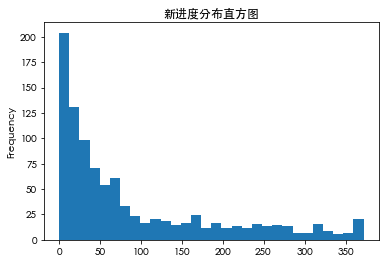

In [29]:
df_user['R值'].sort_values().plot(kind='hist', bins=30, title='新进度分布直方图')  # R值直方图

<AxesSubplot:title={'center':'消费频率分布直方图'}, ylabel='Frequency'>

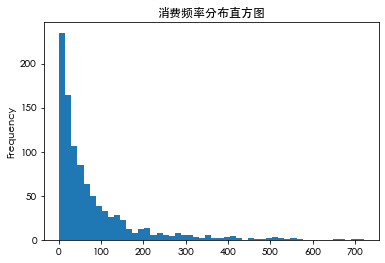

In [26]:
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title = '消费频率分布直方图') #F值直方图

<AxesSubplot:title={'center':'消费金额分布直方图'}, ylabel='Frequency'>

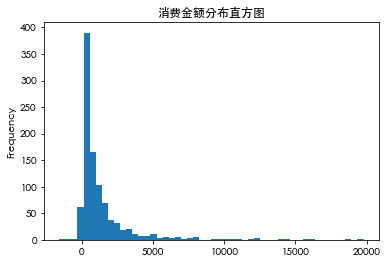

In [27]:
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title = '消费金额分布直方图') #M值直方图

### KMeans

In [31]:
from sklearn.cluster import KMeans  # 导入KMeans模块

def show_elbow(df):  # 定义手肘函数
    distance_list = []  # 聚质心的距离（损失）
    K = range(1, 9)  # K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100)  # 创建KMeans模型
        kmeans = kmeans.fit(df)  # 拟合模型
        distance_list.append(kmeans.inertia_)  # 创建每个K值的损失
    plt.plot(K, distance_list, "bx-")  # 绘图
    plt.xlabel("k")  # X轴
    plt.ylabel("距离均方误差")  # Y轴
    plt.title("k值手肘图")  # 标题

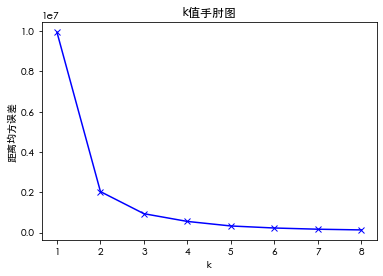

In [33]:
show_elbow(df_user[["R值"]])

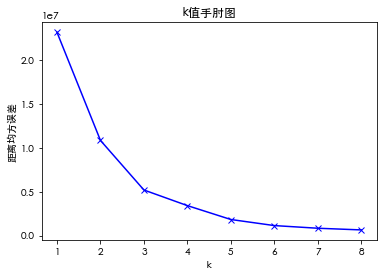

In [34]:
show_elbow(df_user[["F值"]])

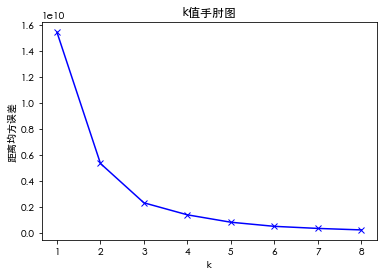

In [38]:
show_elbow(df_user[["M值"]])

In [40]:
kmeans_R = KMeans(n_clusters=3) #设定K=3
kmeans_F = KMeans(n_clusters=4) #设定K=4
kmeans_M = KMeans(n_clusters=4) #设定K=4


kmeans_R.fit(df_user[['R值']]) #拟合模型
kmeans_F.fit(df_user[['F值']]) #拟合模型
kmeans_M.fit(df_user[['M值']]) #拟合模型

KMeans(n_clusters=4)

In [56]:
df_user["R值层级"] = kmeans_R.predict(df_user[["R值"]])

df_user.groupby('R值层级')["R值"].describe()
df_user

,用户码,R值,F值,M值,R值层级
0,14681,70,7,498.95,1
1,14682,187,2,52.00,2
2,14684,25,421,1236.28,1
3,14687,106,15,628.38,2
4,14688,7,359,5107.38,1
...,...,...,...,...,...
980,16015,3,184,690.54,1
981,16016,2,237,1483.31,1
982,16017,46,32,211.88,1
983,16018,38,28,408.90,1


In [69]:
#定义一个order_cluster函数为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    new_cluster_name = 'new_' + cluster_name #新的聚类名称
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) #排序
    df_new['index'] = df_new.index #创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) #基于聚类名称把df_new还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) #删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) #将索引字段重命名为聚类名称字段
    return df_new #返回排序后的df_new对象

df_user.head()
df_user = order_cluster('R值层级', 'R值', df_user, False) #调用簇排序函数
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,139.0,295.978417,44.624921,231.0,254.5,289.0,331.0,372.0
1,177.0,157.141243,36.992127,95.0,126.0,157.0,188.0,225.0
2,669.0,31.272048,25.155162,0.0,9.0,24.0,49.0,94.0


#### F值聚类

In [66]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user = order_cluster('F值层级', 'F值',df_user,True) #调用簇排序函数
df_user.groupby('F值层级')['F值'].describe() #F值层级分组统计信息

F值层级
0      33.223140
1    1325.857143
2     424.461538
3     158.535000
Name: F值, dtype: float64
   F值层级           F值
0     0    33.223140
1     1  1325.857143
2     2   424.461538
3     3   158.535000
   F值层级           F值
0     0    33.223140
1     3   158.535000
2     2   424.461538
3     1  1325.857143
   F值层级           F值  index
0     0    33.223140      0
1     3   158.535000      1
2     2   424.461538      2
3     1  1325.857143      3


,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,726.0,33.223140,25.142678,1.0,12.00,27.0,50.75,95.0
1,200.0,158.535000,51.065716,96.0,117.00,143.0,194.50,286.0
2,52.0,424.461538,111.284208,295.0,338.25,396.0,502.25,720.0
3,7.0,1325.857143,549.089376,925.0,1016.00,1160.0,1336.50,2491.0


#### M值聚类

In [68]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']]) #通过聚类模型求出M值的层级
df_user = order_cluster('M值层级', 'M值',df_user,True) #调用簇排序函数
df_user.groupby('M值层级')['M值'].describe() #M值层级分组统计信息
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

M值层级
0      684.455245
1    46437.762000
2    13467.804444
3     4139.803140
Name: M值, dtype: float64
   M值层级            M值
0     0    684.455245
1     1  46437.762000
2     2  13467.804444
3     3   4139.803140
   M值层级            M值
0     0    684.455245
1     3   4139.803140
2     2  13467.804444
3     1  46437.762000
   M值层级            M值  index
0     0    684.455245      0
1     3   4139.803140      1
2     2  13467.804444      2
3     1  46437.762000      3


,用户码,R值,F值,M值,R值层级,F值层级,M值层级
0,14681,70,7,498.95,2,0,0
1,14682,187,2,52.00,1,0,0
2,14684,25,421,1236.28,2,2,0
3,14687,106,15,628.38,1,0,0
4,14688,7,359,5107.38,2,2,1


In [71]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] #求出每个用户RFM总分

#### 用户总体价值

In [72]:
#在df_user对象中添加总体价值这个字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user #显示df_user

,用户码,R值,F值,M值,F值层级,M值层级,R值层级,总分,总体价值
0,14681,70,7,498.95,0,0,2,2,低价值
1,14682,187,2,52.00,0,0,1,1,低价值
2,14684,25,421,1236.28,2,0,2,4,中价值
3,14687,106,15,628.38,0,0,1,1,低价值
4,14688,7,359,5107.38,2,1,2,5,高价值
...,...,...,...,...,...,...,...,...,...
980,16015,3,184,690.54,1,0,2,3,中价值
981,16016,2,237,1483.31,1,0,2,3,中价值
982,16017,46,32,211.88,0,0,2,2,低价值
983,16018,38,28,408.90,0,0,2,2,低价值


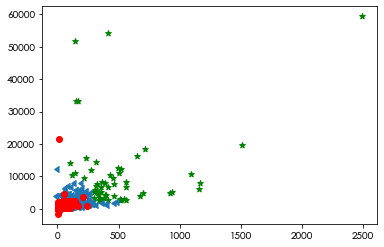

In [76]:
#显示高、中、低价值组分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],
                   df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],
                   df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],
                   df_user.query("总体价值 == '低价值'")['M值'],c='r')



#### 三维图

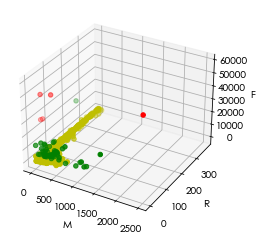

In [77]:
df_user['三维价值'] = KMeans(n_clusters=3).fit(df_user[['R值', 'F值', 'M值']]).predict(df_user[['R值', 'F值', 'M值']])

ax = plt.subplot(111, projection='3d')
ax.scatter(df_user.query("三维价值 == 0")['F值'],
           df_user.query("三维价值 == 0")['R值'],
           df_user.query("三维价值 == 0")['M值'], c='y')
ax.scatter(df_user.query("三维价值 == 1")['F值'],
           df_user.query("三维价值 == 1")['R值'],
           df_user.query("三维价值 == 1")['M值'], c='r')
ax.scatter(df_user.query("三维价值 == 2")['F值'],
           df_user.query("三维价值 == 2")['R值'],
           df_user.query("三维价值 == 2")['M值'], c='g')

ax.set_zlabel('F')  # 坐标轴
ax.set_ylabel('R')
ax.set_xlabel('M')
plt.show()